<a href="https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/GenerateTrainingSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generation of synthetic atomic lattice images

Prepared by Maxim Ziatdinov

In [1]:
!git clone https://github.com/ziatdinovmax/AtomicImageSimulator.git
%cd AtomicImageSimulator/

Cloning into 'AtomicImageSimulator'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 86 (delta 38), reused 28 (delta 11), pack-reused 0
Unpacking objects: 100% (86/86), done.
/content/AtomicImageSimulator


Import modules:

In [0]:
from main import *
import matplotlib.pyplot as plt
# use this for notebook's dark theme
plt.style.use(['dark_background']) 

We can import already existing coordinates or we can generate our own lattice.

In [3]:
directory = 'lattices/'
filename = 'Hex-coordinates-clean.npy'
lattice_coordinates = np.load(directory+filename)
lattice_coordinates

array([['B', '1.23', '0.0'],
       ['B', '2.46', '0.0'],
       ['B', '3.69', '0.0'],
       ...,
       ['B', '121.15499999999999', '126.73499999999999'],
       ['B', '122.38499999999999', '126.73499999999999'],
       ['B', '123.615', '126.73499999999999']], dtype='<U32')

We are now going to simulate an image from these coordinates. First, we specify some parameters for image simulation:

In [0]:
# nearest neighbor (nn) distance
nnd = 1.5
# angstrom to pixel conversion coefficient (do not change)
ang2px = 10.5
# angle to rotate (min, max, step)
ang = (0, 180, 5)
# list atom "widths" (better to keep it below 15)
sc = [11, 13] 
# number of holes to be introduced
n_holes = 5
# size of the largest hole (in the nn distance units)
r_hole = 5
# random displacement of atomic poision (0 to 1)
randomize = .15
# blurring due to overlap with a probe
convprobe = 1.5
# Type of impurity 1
impurity1 = 'Si'
# Type of impurity 2
impurity2 = 'O'
# Amount of impurity 1  (set to 0 if no impurities)
n_impurity1 = 2000
# Amount of impurity 2 (4-fold dopant - works only in honeycomb lattice!)
n_impurity2 = 0

Now we simulate an image itself:

In [0]:
sl = SimulateLattice(
    lattice_coordinates, ang2px, ang, sc, nnd,
    randomize, convprobe, n_holes, r_hole,
    impurity1, impurity2, n_impurity1, n_impurity2)
imgsrc, mask = sl.make_image(r_mask=5)

Plot a result:

(0, 1433)

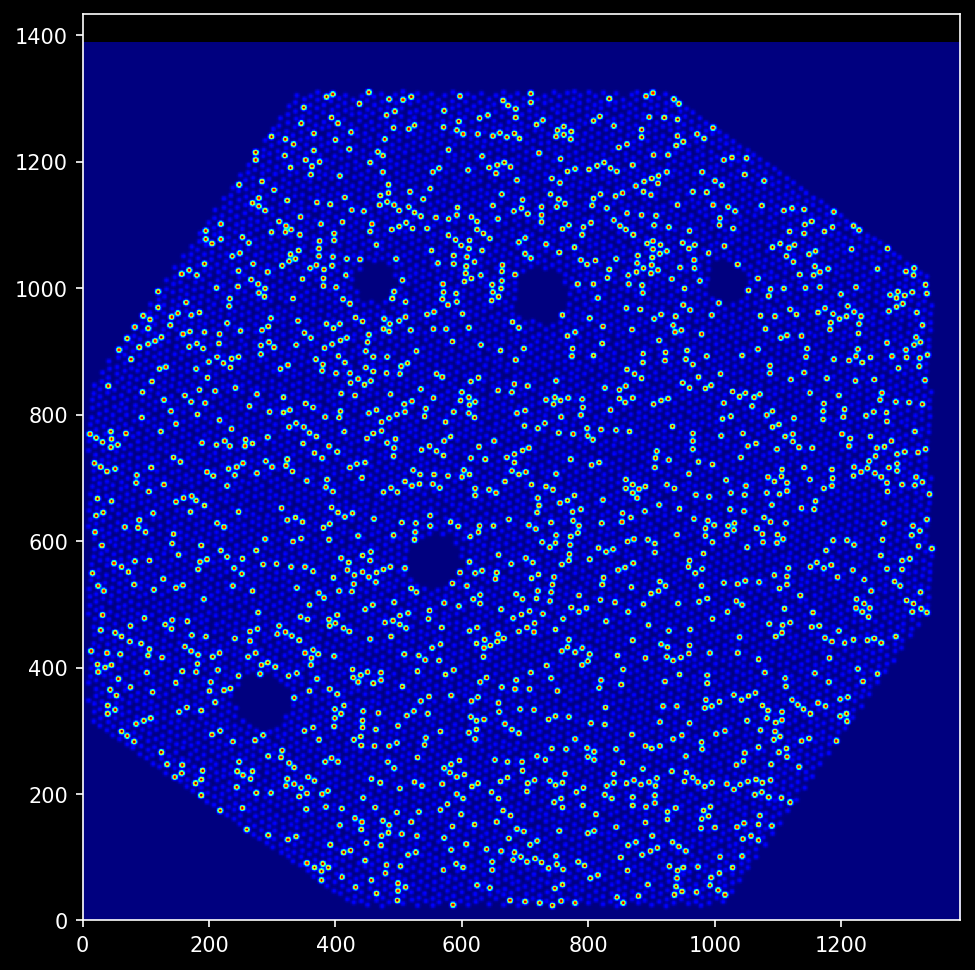

In [7]:
plt.figure(figsize=(8, 8), dpi = 150)
plt.imshow(imgsrc, cmap = 'jet')
plt.xlim(0, imgsrc.shape[0])
plt.ylim(0, imgsrc.shape[1])

We can next perform a data augmentation procedure. First, we produce a stack of cropped images by sliding a window of size $w \times h$ across the original image with a step of size $s$ and extracting the image portion that ovelpaps with the window at each step. Then we apply various transformations/distortions (such as different forms of noise) to each image in the stack.

Note: If you don't want a certain transformation to be applied, just remove it from data_transform initialization.

In [0]:
# Define parameters of image croppping
window_size = (256, 256)
step_size = 128
batch_size = 5
# Define image distortion/noise parameters
zoom = (64, 128+16, 16)
scars = False
resize = 256
# Noise parameters are defined as dictionary
noise_dict = {}
noise_dict['poisson'] = (80, 120) # range (smaller values --> higher noise)
noise_dict['gauss'] = (0, 100) # range (smaller values --> lower noise)
noise_dict['blur'] = (1, 6)
noise_dict['contrast'] = (8, 14)
noise_dict['salt and pepper'] = (0, 10)

Define a function for batch generation:

TODO: define it properly in utils.py

In [0]:
def generate_batches(batch_size):
    
    sl = SimulateLattice(lattice_coordinates, ang2px, ang, sc,
                 nnd, randomize, convprobe, n_holes, r_hole,
                 impurity1, impurity2, n_impurity1, n_impurity2)
    imgsrc, mask = sl.make_image(r_mask=5)
    imcrop = cropper(imgsrc, mask, window_size, step_size, batch_size)
    images, labels = imcrop.imgen()
    imaug = data_transform(
        batch_size, window_size[0], window_size[1],  mask.shape[-1],
        multichannel=True, noise=noise_dict, zoom=zoom, scars=scars, resize=resize)
    images, labels = imaug.transform(images, labels)
    yield images, labels

Generate a trial batch of training data with corresponding labels / ground truth:

In [0]:
X_batch, y_batch = next(generate_batches(batch_size=10))

Plot the generated data:

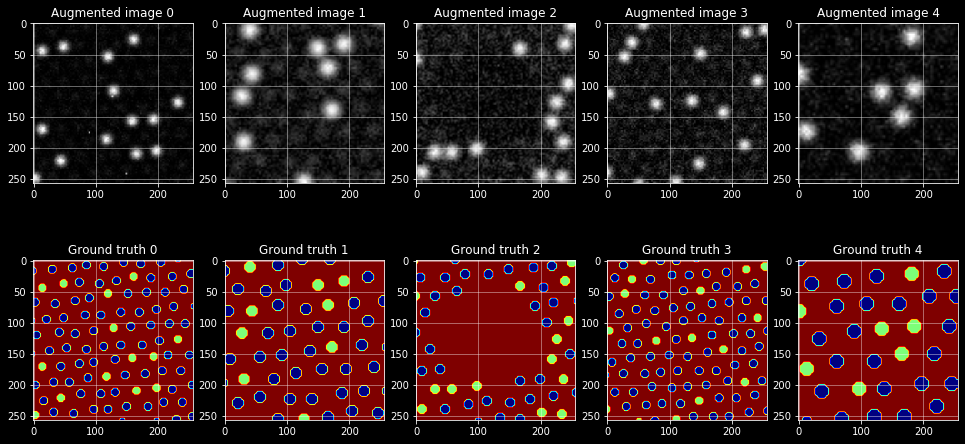

In [28]:
n = 5 # number of pairs to plot

n = n + 1
fig = plt.figure( figsize=(20, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(X_batch[i-1,0,:,:], cmap = 'gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(squeeze_channels(y_batch)[i-1,:,:], 
              Interpolation='Gaussian', cmap = 'jet')
    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha = 0.5)

Now generate the entire training set (for semantic segmentation type of problem, it is better to have > 1500 image-label pairs): 

In [29]:
n_batches = 50
batch_size = 32
n_atom_types = 2 # specify how many atom types you have in your data

X_train, y_train = [], []
i = 0
while i < n_batches:
    print('\rPreparing batch {} / {}'.format(i+1, n_batches), end="")
    X_batch, y_batch = next(generate_batches(batch_size))
    batch_labels = [len(np.unique(y)) for y in squeeze_channels(y_batch)]
    if len(set(batch_labels)) == 1 and list(set(batch_labels))[0] == n_atom_types + 1:
        X_train.append(X_batch)
        y_train.append(squeeze_channels(y_batch))
        i += 1

Preparing batch 50 / 50

Plot results for the selected batch:

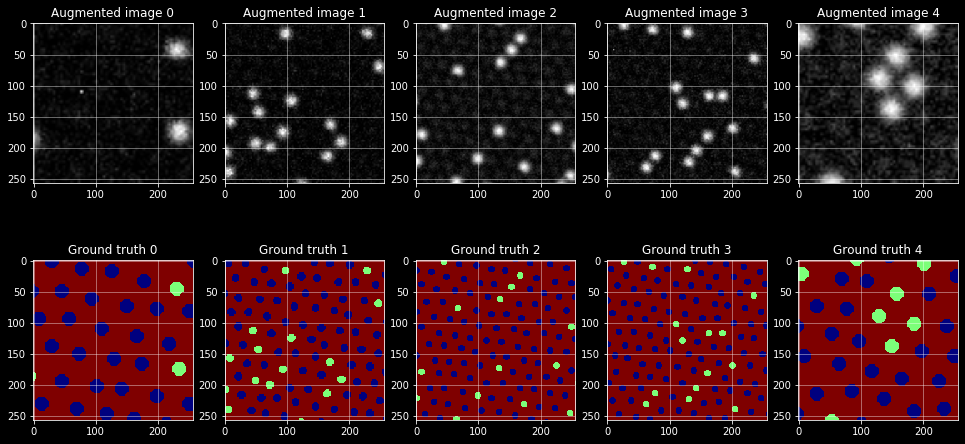

In [30]:
batch_num = 5 # batch number (number of element in the list)
n = 5 # num of pairs to display

x = X_train[batch_num]
y = y_train[batch_num]
n = n + 1
fig = plt.figure( figsize=(20, 8))
for i in range(1, n):   
    ax = fig.add_subplot(2, n, i)
    ax.imshow(x[i-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha=0.5)
    ax = fig.add_subplot(2, n, i+n)
    ax.imshow(y[i-1,:,:], cmap='jet')
    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha = 0.5)

Here we can also split our data into training and test sets:

In [0]:
thresh = int(n_batches * .75) # ~ 75-25 split
X_train, X_test = X_train[:thresh], X_train[thresh:]
y_train, y_test = y_train[:thresh], y_train[thresh:]

Save the prepared data:

(if using Google Colab, mount first a GDrive and save to the drive)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
savedir = '/content/drive/My Drive/SimulatedAtomicImages/' # modify as neccessary
np.savez(savedir+'Hex_train_test.npz',
         X_train=X_train,y_train=y_train,
         X_test=X_test, y_test=y_test)